# Research Dataset Preparation
This notebook prepares a research dataset to analyze the relationship between audio features and song success over different eras.

In [218]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [219]:
df = pd.read_csv('data/song_hits_and_audio_features.csv')
df.isnull().sum()

Track               0
Artist              0
Year                0
Duration            0
Time_Signature      0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Popularity          0
Genre               0
dtype: int64

In [220]:
df = df.rename(columns={"Track": "name"})
df.columns = df.columns.str.lower()
# changing duration from milliseconds to minutes
df["duration"] = (df["duration"] / 60000).round(2)
df.head()

,name,artist,year,duration,time_signature,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,genre
0,Hey Jack Kerouac,"10,000 Maniacs",1987,3.44,4,0.616,0.511,6,-15.894,1,0.0279,0.03840,0.000000,0.1500,0.604,132.015,40,Alt. Rock
1,Like the Weather,"10,000 Maniacs",1987,3.94,4,0.770,0.459,1,-17.453,1,0.0416,0.11200,0.003430,0.1450,0.963,133.351,43,Alt. Rock
2,What's the Matter Here?,"10,000 Maniacs",1987,4.85,4,0.593,0.816,9,-7.293,1,0.0410,0.00449,0.000032,0.0896,0.519,99.978,12,Alt. Rock
3,Trouble Me,"10,000 Maniacs",1989,3.23,4,0.861,0.385,2,-10.057,1,0.0341,0.15400,0.000000,0.1230,0.494,117.913,47,Alt. Rock
4,Candy Everybody Wants,"10,000 Maniacs",1992,3.10,4,0.622,0.876,10,-6.310,1,0.0305,0.01930,0.006840,0.0987,0.867,104.970,43,Alt. Rock


In [221]:
from sklearn.preprocessing import StandardScaler

# 1 creating scaled cols (standardise) to later feature engineer
scaler = StandardScaler()

df['loudness_scaled'] = scaler.fit_transform(df[['loudness']])
df['energy_scaled'] = scaler.fit_transform(df[['energy']])
df['acousticness_scaled'] = scaler.fit_transform(df[['acousticness']])
df['danceability_scaled'] = scaler.fit_transform(df[['danceability']])
df['valence_scaled'] = scaler.fit_transform(df[['valence']])

# 2. creating new cols of features that are highly correlated
df['intensity'] = df[['energy_scaled', 'loudness_scaled']].mean(axis=1)
df['production_style'] = df[['energy_scaled', 'acousticness_scaled']].mean(axis=1)
df['feel_good_factor'] = df[['danceability_scaled', 'valence_scaled']].mean(axis=1)

# audio_features = ['feel_good_factor', 'intensity', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']
audio_features = ['danceability', 'valence', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo',
                  'energy', 'loudness']

df["era"] = pd.cut(df["year"], bins=[1889, 1969, 1979, 1989, 1999, 2009, 2029],
                   labels=["<=60s", "70s", "80s", "90s", "00s", ">=10s"])

# Now you have a new feature called 'intensity' that captures their combined effect!

#### Define Success within Each Era
if the song's popularity is in the top 20% of its era, it is considered a "hit" (is_success = 1), otherwise it is not a hit (is_success = 0).

In [222]:
songs_past_20_years = df[df['era'].isin(['00s', '>=10s'])].copy()
songs_past_20_years.head(10)
songs_past_20_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3421 entries, 9 to 15149
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   name              3421 non-null   object  
 1   artist            3421 non-null   object  
 2   year              3421 non-null   int64   
 3   duration          3421 non-null   float64 
 4   time_signature    3421 non-null   int64   
 5   danceability      3421 non-null   float64 
 6   energy            3421 non-null   float64 
 7   key               3421 non-null   int64   
 8   loudness          3421 non-null   float64 
 9   mode              3421 non-null   int64   
 10  speechiness       3421 non-null   float64 
 11  acousticness      3421 non-null   float64 
 12  instrumentalness  3421 non-null   float64 
 13  liveness          3421 non-null   float64 
 14  valence           3421 non-null   float64 
 15  tempo             3421 non-null   float64 
 16  popularity        3421 non-n

In [223]:
# Let's see the distribution of the popularity column
print(songs_past_20_years['popularity'].describe(percentiles=[.7, .75, .8, .85, .9]))

count    3421.000000
mean       50.317159
std        20.117759
min         0.000000
50%        52.000000
70%        63.000000
75%        66.000000
80%        69.000000
85%        72.000000
90%        76.000000
max        98.000000
Name: popularity, dtype: float64


In [224]:
# --- Replace 70 with your chosen absolute popularity threshold ---
ABSOLUTE_SUCCESS_THRESHOLD = 63

# Create the new, cleaner success column on your filtered DataFrame
songs_past_20_years['is_success'] = (songs_past_20_years['popularity'] >= ABSOLUTE_SUCCESS_THRESHOLD).astype(int)

# See the new class balance
print(f"\nUsing a threshold of {ABSOLUTE_SUCCESS_THRESHOLD}, we have:")
print(songs_past_20_years['is_success'].value_counts())


Using a threshold of 63, we have:
is_success
0    2368
1    1053
Name: count, dtype: int64


In [225]:


# Config: adjust if your columns differ
GENRE_COL = 'genre'
ARTIST_COL = 'artist'
SUCCESS_COL = 'is_success'

songs_past_20_years = songs_past_20_years.astype({'genre': 'category', 'artist': 'category'})
songs_past_20_years[ARTIST_COL].info()


<class 'pandas.core.series.Series'>
Index: 3421 entries, 9 to 15149
Series name: artist
Non-Null Count  Dtype   
--------------  -----   
3421 non-null   category
dtypes: category(1)
memory usage: 54.3 KB


In [226]:
songs_per_artist = songs_past_20_years["artist"].value_counts()
mean_per_artist = songs_per_artist.mean()
median_per_artists = songs_per_artist.median()
print(f"average number of songs per artist : {mean_per_artist}")
print(f"median number of songs per artist : {median_per_artists}")

average number of songs per artist : 5.608196721311476
median number of songs per artist : 6.0


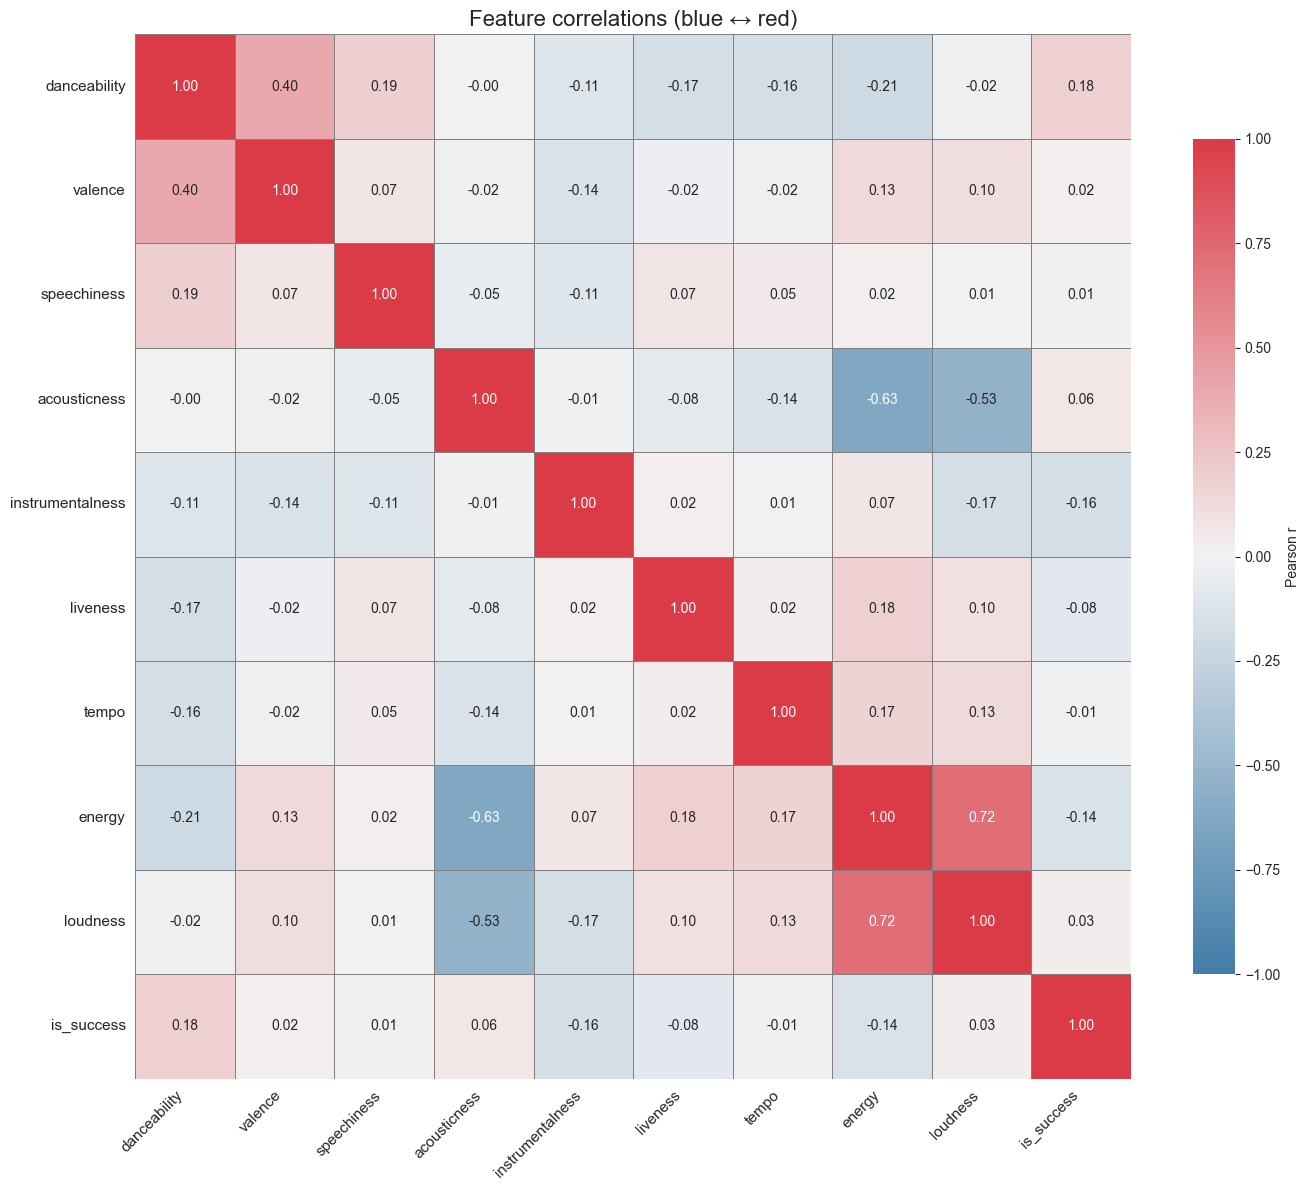

In [227]:

# --- Ensure you have a numeric success column ---
# This is a placeholder; replace 'success' with your actual numeric success column name
# and 'era' with your era column name.
SUCCESS_COL = 'is_success'

# List of audio features you want to analyze
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
df_heatmap = songs_past_20_years[audio_features + [SUCCESS_COL]]
corrs = df_heatmap.corr()
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    corrs,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    center=0,
    linewidths=.5,
    linecolor='gray',
    cbar_kws={"shrink": .8, "label": "Pearson r"},
    annot_kws={"size": 10},
    ax=ax
)
# Tidy ticks and title
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
ax.set_title("Feature correlations (blue ↔ red)", fontsize=16)
plt.tight_layout()
plt.show()

Average Success Rate by Genre:
genre
Today        0.688710
Alt. Rock    0.524887
R&B          0.509091
Rap          0.464491
Country      0.428571
EDM          0.197605
Metal        0.194986
Funk         0.052632
Reggae       0.051546
Gospel       0.037267
Punk         0.028302
SKA          0.025862
Rock         0.010256
Jazz         0.000000
Blues        0.000000
Folk         0.000000
Disco        0.000000
World        0.000000
Name: is_success, dtype: float64


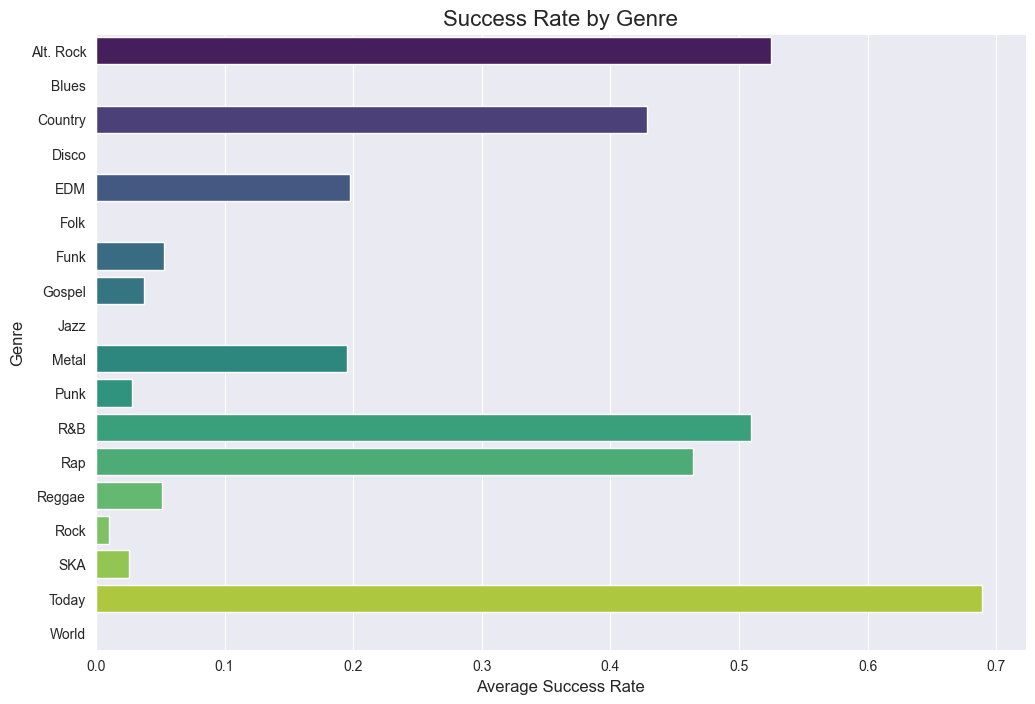

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Make sure to replace these with your actual column names ---
GENRE_COL = 'genre'
SUCCESS_COL = 'is_success'  # Assuming 1 for success, 0 for not

# Calculate the average success rate for each genre
genre_success_rate = songs_past_20_years.groupby(GENRE_COL, observed=True)[SUCCESS_COL].mean().sort_values(
    ascending=False)

print("Average Success Rate by Genre:")
print(genre_success_rate)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_success_rate.values, y=genre_success_rate.index, hue=genre_success_rate.index, legend=False,
            palette='viridis')
plt.title('Success Rate by Genre', fontsize=16)
plt.xlabel('Average Success Rate', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

#### Random Forest Classifier that take genre into account

Preprocessing the full dataset...
Training the model with balanced class weights...

Model Out-of-Bag (OOB) Accuracy: 0.770

--- OOB Metrics with Balanced Weights (0.5 Threshold) ---
              precision    recall  f1-score   support

 Not Success       0.80      0.89      0.84      2368
     Success       0.67      0.51      0.58      1053

    accuracy                           0.77      3421
   macro avg       0.73      0.70      0.71      3421
weighted avg       0.76      0.77      0.76      3421



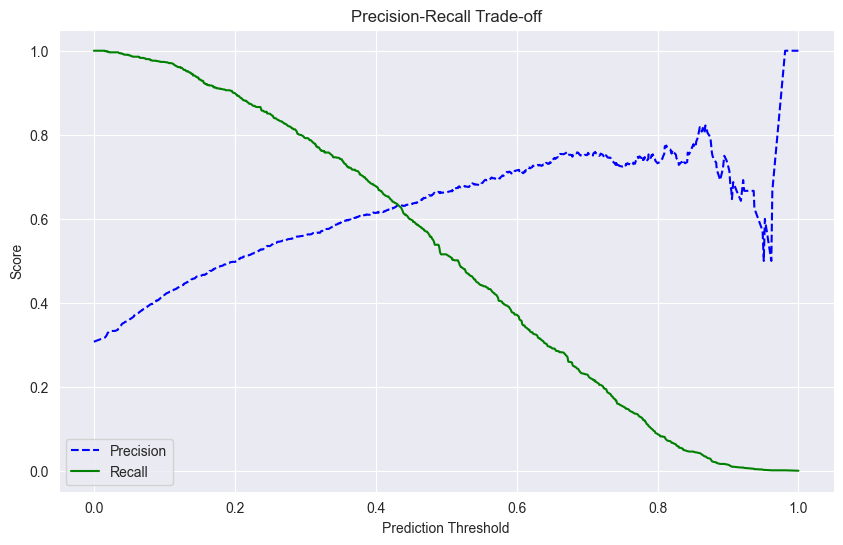


--- OOB Metrics with New Threshold (0.75) ---
              precision    recall  f1-score   support

 Not Success       0.72      0.97      0.83      2368
     Success       0.72      0.15      0.26      1053

    accuracy                           0.72      3421
   macro avg       0.72      0.56      0.54      3421
weighted avg       0.72      0.72      0.65      3421

New Positive Predictive Value (Precision) at 0.75 threshold: 0.724


In [229]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, precision_score, classification_report
import matplotlib.pyplot as plt

# --- Define your columns ---
GENRE_COL = 'genre'
TARGET_COL = 'is_success'

# --- Prepare Data ---
X = songs_past_20_years[audio_features + [GENRE_COL]]
y = songs_past_20_years[TARGET_COL].astype(int)

# --- Preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', StandardScaler(), audio_features),
        ('genre', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [GENRE_COL])
    ],
    remainder='passthrough'
)
print("Preprocessing the full dataset...")
X_transformed = preprocessor.fit_transform(X)

# --- Train the Model with Balanced Weights ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    class_weight='balanced'  # <--- KEY CHANGE 1: Address class imbalance
)

print("Training the model with balanced class weights...")
model.fit(X_transformed, y)
print(f"\nModel Out-of-Bag (OOB) Accuracy: {model.oob_score_:.3f}")

# --- Evaluate the balanced model (at default 0.5 threshold) ---
y_oob_pred_balanced = np.argmax(model.oob_decision_function_, axis=1)
print("\n--- OOB Metrics with Balanced Weights (0.5 Threshold) ---")
print(classification_report(y, y_oob_pred_balanced, target_names=['Not Success', 'Success']))

# --- KEY CHANGE 2: Find and Apply a Better Threshold for High Precision ---
# Get the predicted probabilities for the "Success" class from OOB
oob_probabilities = model.oob_decision_function_[:, 1]

# Generate precision-recall data
precisions, recalls, thresholds = precision_recall_curve(y, oob_probabilities)

# Plot the Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.title('Precision-Recall Trade-off')
plt.xlabel('Prediction Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# --- Apply a new, higher threshold to boost precision ---
NEW_THRESHOLD = 0.75  # Let's try 70%. You can adjust this based on the graph above.

# Get new predictions based on our custom threshold
y_oob_pred_high_precision = (oob_probabilities >= NEW_THRESHOLD).astype(int)

print(f"\n--- OOB Metrics with New Threshold ({NEW_THRESHOLD}) ---")
print(classification_report(y, y_oob_pred_high_precision, target_names=['Not Success', 'Success']))

new_ppv = precision_score(y, y_oob_pred_high_precision)
print(f"New Positive Predictive Value (Precision) at {NEW_THRESHOLD} threshold: {new_ppv:.3f}")

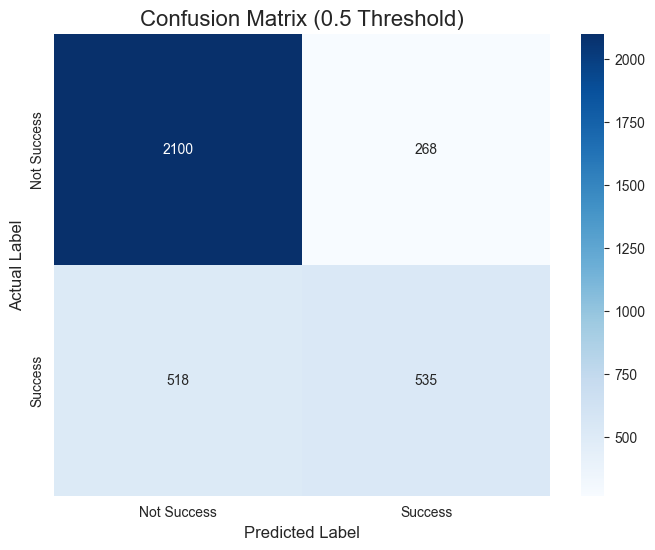

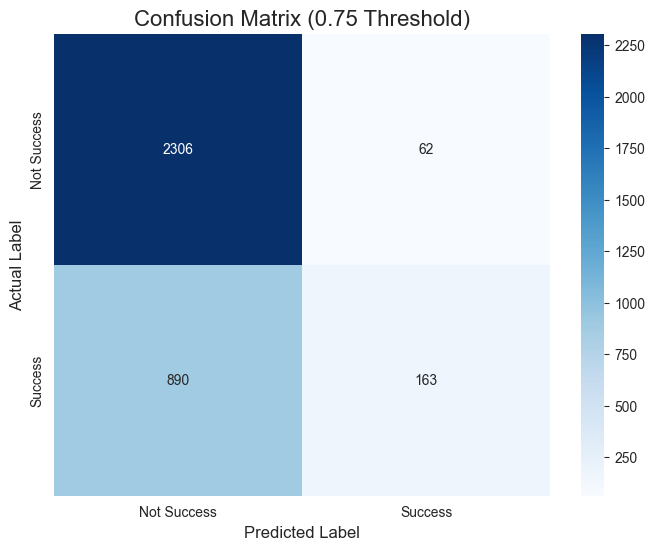

In [231]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# (This code goes after the rest of your script, where you've already calculated the predictions)

# --- Function to plot a confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Success', 'Success'],
                yticklabels=['Not Success', 'Success'])
    plt.title(title, fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()


# --- 1. Plot Confusion Matrix for the model with the default 0.5 threshold ---
plot_confusion_matrix(y, y_oob_pred_balanced, 'Confusion Matrix (0.5 Threshold)')

# --- 2. Plot Confusion Matrix for the high-precision model (0.75 threshold) ---
plot_confusion_matrix(y, y_oob_pred_high_precision, f'Confusion Matrix ({NEW_THRESHOLD} Threshold)')

Preprocessing the full dataset...
Training the model on the full dataset...

Model Out-of-Bag (OOB) Accuracy: 0.770
Positive Predictive Value (Precision) for 'Success': 0.666

Full OOB Classification Report:
              precision    recall  f1-score   support

 Not Success       0.80      0.89      0.84      2368
     Success       0.67      0.51      0.58      1053

    accuracy                           0.77      3421
   macro avg       0.73      0.70      0.71      3421
weighted avg       0.76      0.77      0.76      3421


Calculating feature importance...


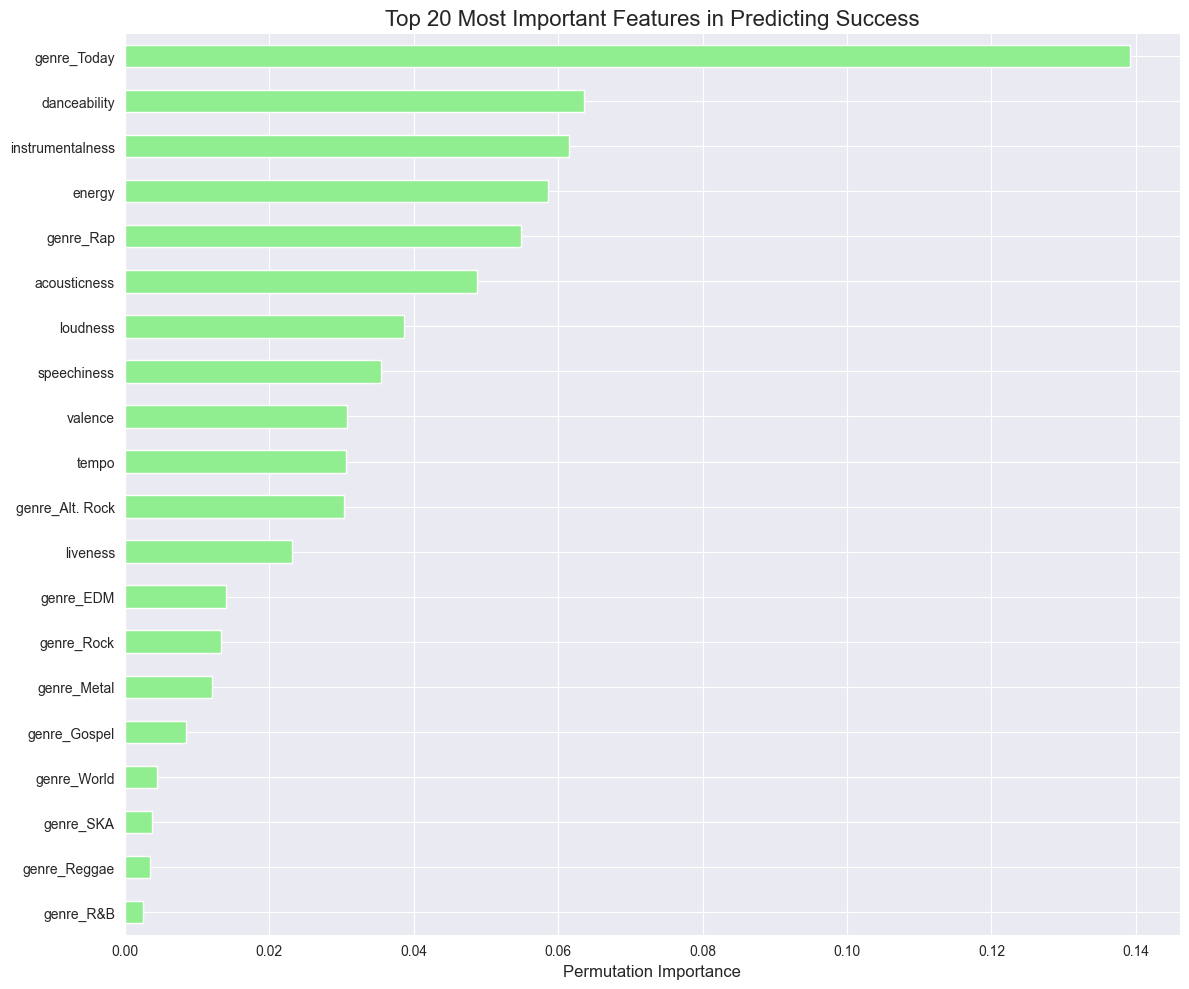


Top 10 most important features:
genre_Today         0.139141
danceability        0.063519
instrumentalness    0.061473
energy              0.058550
genre_Rap           0.054896
acousticness        0.048787
loudness            0.038644
speechiness         0.035428
valence             0.030839
tempo               0.030576
dtype: float64


In [230]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, classification_report  # Import metrics
import matplotlib.pyplot as plt

# --- Define your columns (replace if necessary) ---
GENRE_COL = 'genre'
TARGET_COL = 'is_success'

# --- Prepare Data using the full dataset ---
X = songs_past_20_years[audio_features + [GENRE_COL]]
y = songs_past_20_years[TARGET_COL].astype(int)

# --- Create and Fit the Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', StandardScaler(), audio_features),
        ('genre', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [GENRE_COL])
    ],
    remainder='passthrough'
)

print("Preprocessing the full dataset...")
X_transformed = preprocessor.fit_transform(X)

# --- Get the Correct Feature Names After Transformation ---
encoded_genre_names = preprocessor.named_transformers_['genre'].get_feature_names_out([GENRE_COL])
all_feature_names = np.array(audio_features + list(encoded_genre_names))

# --- Train the Model on the Full Dataset ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True
)

print("Training the model on the full dataset...")
model.fit(X_transformed, y)
print(f"\nModel Out-of-Bag (OOB) Accuracy: {model.oob_score_:.3f}")

# --- NEW: Calculate PPV (Precision) and other metrics from OOB predictions ---
# Get the OOB predictions for each song
y_oob_pred = np.argmax(model.oob_decision_function_, axis=1)

# Calculate Positive Predictive Value (Precision) for the "success" class (class 1)
ppv = precision_score(y, y_oob_pred, pos_label=1)
print(f"Positive Predictive Value (Precision) for 'Success': {ppv:.3f}")

# For a complete picture, let's look at the full classification report
print("\nFull OOB Classification Report:")
# target_names=['Not Success', 'Success'] helps label the report
print(classification_report(y, y_oob_pred, target_names=['Not Success', 'Success']))

# --- Find and Plot Feature Importance ---
print("\nCalculating feature importance...")
result = permutation_importance(
    model, X_transformed, y, n_repeats=10, random_state=42, n_jobs=-1
)

importances = pd.Series(result.importances_mean, index=all_feature_names).sort_values()

# --- Plot the Results ---
plt.figure(figsize=(12, 10))
importances.tail(20).plot(kind='barh', color='lightgreen')
plt.title('Top 20 Most Important Features in Predicting Success', fontsize=16)
plt.xlabel('Permutation Importance', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importances.sort_values(ascending=False).head(10))

#### Random Forest Classfier for feature imporense

Preprocessing the full dataset...
Training the model on the full dataset...

Model Out-of-Bag (OOB) Accuracy: 0.702
Positive Predictive Value (Precision) for 'Success': 0.532

Full OOB Classification Report:
              precision    recall  f1-score   support

 Not Success       0.73      0.90      0.81      2368
     Success       0.53      0.26      0.35      1053

    accuracy                           0.70      3421
   macro avg       0.63      0.58      0.58      3421
weighted avg       0.67      0.70      0.67      3421


Calculating feature importance...


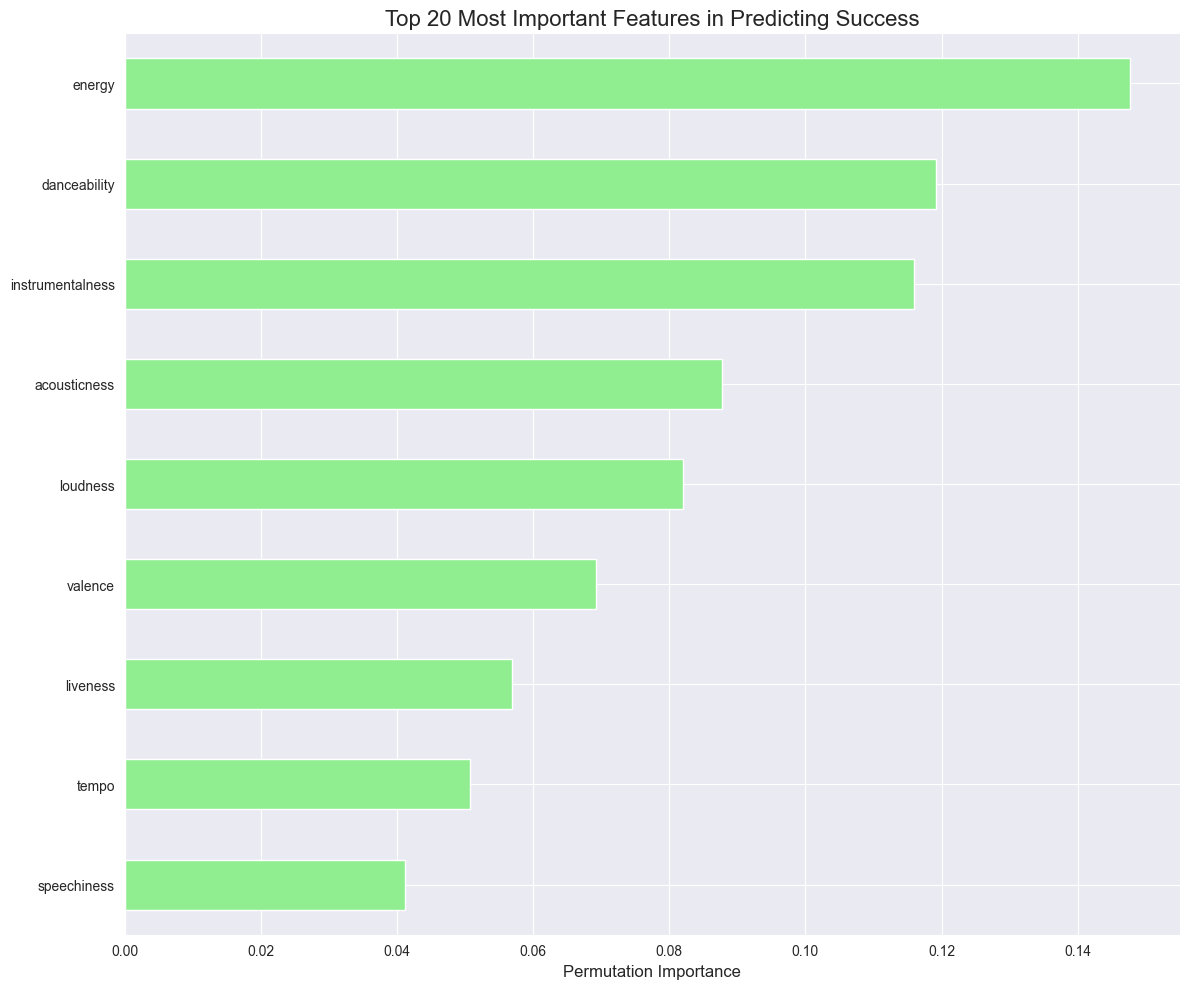


Top 10 most important features:
energy              0.147647
danceability        0.119176
instrumentalness    0.115960
acousticness        0.087811
loudness            0.082081
valence             0.069249
liveness            0.056942
tempo               0.050658
speechiness         0.041128
dtype: float64


In [234]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, classification_report  # Import metrics

# --- Define your columns (replace if necessary) ---
TARGET_COL = 'is_success'

# --- Prepare Data using the full dataset ---
X = songs_past_20_years[audio_features]
y = songs_past_20_years[TARGET_COL].astype(int)

# --- Create and Fit the Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', StandardScaler(), audio_features),
    ],
    remainder='passthrough'
)

print("Preprocessing the full dataset...")
X_transformed = preprocessor.fit_transform(X)

# --- Get the Correct Feature Names After Transformation ---
all_feature_names = np.array(audio_features)

# --- Train the Model on the Full Dataset ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True
)

print("Training the model on the full dataset...")
model.fit(X_transformed, y)
print(f"\nModel Out-of-Bag (OOB) Accuracy: {model.oob_score_:.3f}")

# --- NEW: Calculate PPV (Precision) and other metrics from OOB predictions ---
# Get the OOB predictions for each song
y_oob_pred = np.argmax(model.oob_decision_function_, axis=1)

# Calculate Positive Predictive Value (Precision) for the "success" class (class 1)
ppv = precision_score(y, y_oob_pred, pos_label=1)

# --- Find and Plot Feature Importance ---
print("\nCalculating feature importance...")
result = permutation_importance(
    model, X_transformed, y, n_repeats=10, random_state=42, n_jobs=-1
)

importances = pd.Series(result.importances_mean, index=all_feature_names).sort_values()

# --- Plot the Results ---
plt.figure(figsize=(12, 10))
importances.tail(20).plot(kind='barh', color='lightgreen')
plt.title('Top 20 Most Important Features in Predicting Success', fontsize=16)
plt.xlabel('Permutation Importance', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importances.sort_values(ascending=False).head(10))